In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using Zygote, Lux, ComponentArrays, Plots, QuadGK, Optimisers, PhasorNetworks, NNlib
using Random: Xoshiro
using MLUtils: DataLoader

In [3]:
using ChainRulesCore: ignore_derivatives

In [4]:
using Base: @kwdef

# Load the dataset

In [5]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [6]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [7]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [8]:
data_dir = "pixel_data/"

"pixel_data/"

In [9]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [10]:
q, ylocal, pt = get_samples(data_dir, 1:2)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [11]:
ylimits = extrema(ylocal) .* 2.0

(-16.1073, 16.3671)

In [12]:
q_test, ylocal_test, pt_test = get_samples(data_dir, 3);

In [13]:
q |> size

(20, 13, 21, 99991)

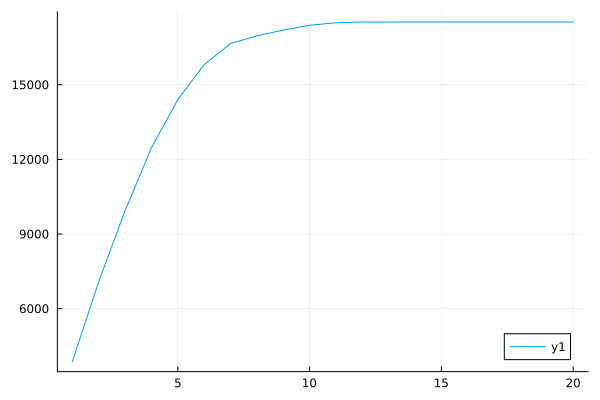

In [14]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

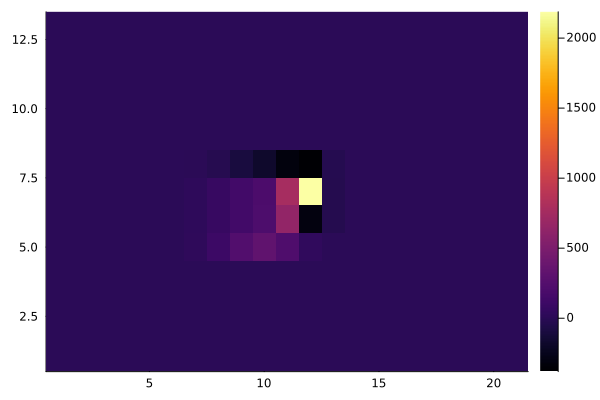

In [15]:
heatmap(q[1,:,:,128])

In [16]:
ylocal |> size

(99991,)

In [17]:
pt |> size

(99991,)

In [18]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [19]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [20]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [21]:
#dimensions - (t, y, x, b): (time, y, x, batch)

In [22]:
x |> size

(20, 13, 21, 128)

In [23]:
n_px = size(x, 2) 
n_in = n_px + 1

14

# Set up the model

In [24]:
"""
Provide a function which approximates the amount of current flowing into a pixel at an arbitrary time by interpolation
"""
function charge_to_current(q)
    #interpolate the amount of charge in a pixel at a moment in time
    q = scale_charge(q)
    fit = interpolate_charge(q)
    n_batch = size(q, 4)
    n_px = size(q, 2) * size(q,3)
    #scale that charge by maximum expected values and interpolate the currents via a gradient
    #current_fn = x -> interpolate_current(fit, x)
    #scale time by the number of samples
    n_t = size(q,1)
    current_fn(t) = Zygote.forwarddiff(x -> interpolate_current(fit, x), t * n_t)
    return current_fn
end

charge_to_current

In [25]:
ifn = charge_to_current(x)

(::var"#current_fn#29"{Int64, Interpolations.FilledExtrapolation{Float64, 4, Interpolations.BSplineInterpolation{Float64, 4, OffsetArrays.OffsetArray{Float64, 4, Array{Float64, 4}}, BSpline{Quadratic{Reflect{OnCell}}}, NTuple{4, Base.OneTo{Int64}}}, BSpline{Quadratic{Reflect{OnCell}}}, Float64}}) (generic function with 1 method)

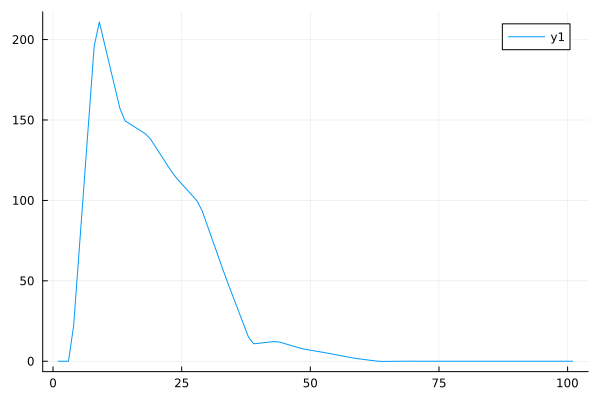

In [26]:
plot([sum(ifn(t)) for t in 0.0:0.01:1.0])

In [27]:
using PhasorNetworks: gaussian_kernel

In [28]:
sa = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [29]:
y_range = ylimits[2] - ylimits[1]

32.4744

In [30]:
# function ylocal_to_current(t::Real, y_local::AbstractArray, spk_args::SpikingArgs; sigma::Real = 9.0, y_range::Real = 32.5)
#     out = zero(y_local)
#     ignore_derivatives() do
#         y_local /= y_range
#         train = phase_to_train(y_local, spk_args=spk_args)

#         #add currents into the active synapses
#         current_kernel = x -> gaussian_kernel(x, t, spk_args.t_window)
#         impulses = current_kernel(train.times)
#         out += impulses
#     end
#     return out
# end

In [31]:
function phase_to_time(phases::AbstractArray, period::Real, offset::Real = 0.0)
    #convert a potential to the time at which the voltage is maximum - 90* behind phase
    phases = (phases ./ 2.0) .+ 0.5
    times = phases .* period
    #add any additional offset
    times .+= offset
    #make all times positive
    times = mod.(times, period)
   
    return times
end

phase_to_time (generic function with 2 methods)

In [32]:
function ylocal_to_current(t::Real, y_local::AbstractArray, spk_args::SpikingArgs; sigma::Real = 9.0, y_range::Real = 32.5)
    y_local /= y_range
    phases = (y_local ./ 2.0) .+ 0.5
    times = phases .* spk_args.t_period
    times = mod.(times, spk_args.t_period)

    #add currents into the active synapses
    current_kernel = x -> gaussian_kernel(x, t, spk_args.t_window)
    impulses = current_kernel(times)

    return impulses
end

ylocal_to_current (generic function with 1 method)

In [33]:
yfn = t -> ylocal_to_current(t, xl, sa)

#36 (generic function with 1 method)

In [34]:
ylocal_is = stack([yfn(t) for t in 0.0:0.01:1.0], dims=1);

In [35]:
maxis = getindex.(argmax(ylocal_is, dims=1), 1)

1×128 Matrix{Int64}:
 40  44  39  47  48  45  50  54  51  …  45  41  43  61  60  62  56  51  49

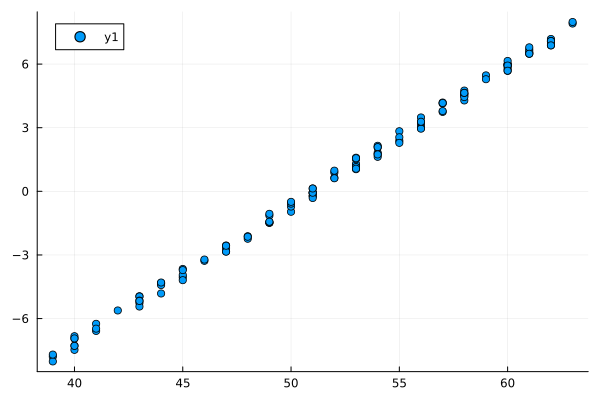

In [36]:
scatter(vec(maxis), xl)

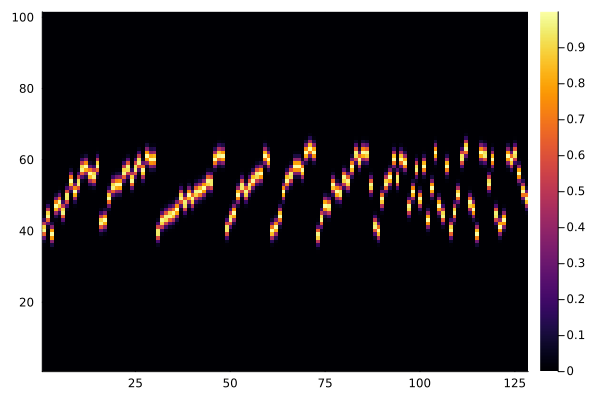

In [37]:
heatmap(ylocal_is)

In [38]:
# function sample_current(t, x, i_fn)
#     i0 = zeros((size(x,2), size(x,4)))
#     ignore_derivatives() do
#         i = sum(i_fn(t), dims=(2))
#         i = dropdims(i, dims=2)
#         i0 += i
#     end
#     return i0
# end

In [39]:
function sample_current(t, x, i_fn)
    i = sum(i_fn(t), dims=(2))
    i = i[:,1,:]

end

sample_current (generic function with 1 method)

In [40]:
sample_current(0.5, x, ifn)

13×128 Matrix{Float64}:
  7.61001e-20  -6.04765e-19   1.00605e-20  …   1.51405e-18  -4.95106e-19
  3.43674e-19  -1.37452e-5   -4.71986e-18     -3.09376e-6   -3.03909e-18
 -9.15347e-6   -0.000169684   8.52827e-5       0.000469456   3.14147e-5
 -0.000164966  -0.000141937  -0.000500777      0.0257679    -0.000618297
 -0.0001106     0.0115677     0.00029367       0.0281326     0.0195163
  0.000152196   0.0117219     0.00593058   …   0.0275934     0.0200012
  0.0107537     0.0116899     0.00688572       0.000232359   0.0199275
  0.0107857     0.000183482   0.00685864      -1.20308e-17   0.000515739
  0.0106241    -1.56441e-18   0.000856318     -2.27577e-18   2.32305e-18
  1.28436e-7   -1.61426e-19   1.27177e-18      2.05228e-19  -1.51263e-18
  1.75669e-18   3.30488e-19   5.82546e-19  …   2.83099e-20  -2.9677e-19
  4.47019e-19   5.34478e-20  -5.50065e-21     -7.98191e-21   3.76279e-20
  7.0738e-20    7.56889e-21  -2.76433e-20     -9.45072e-22   7.74002e-21

In [41]:
sfn = t -> sample_current(t, x, ifn)

#40 (generic function with 1 method)

In [42]:
cat(sfn(0.5), reshape(yfn(0.5), (1,:)), dims=1)

14×128 Matrix{Float64}:
  7.61001e-20  -6.04765e-19   1.00605e-20  …   1.51405e-18  -4.95106e-19
  3.43674e-19  -1.37452e-5   -4.71986e-18     -3.09376e-6   -3.03909e-18
 -9.15347e-6   -0.000169684   8.52827e-5       0.000469456   3.14147e-5
 -0.000164966  -0.000141937  -0.000500777      0.0257679    -0.000618297
 -0.0001106     0.0115677     0.00029367       0.0281326     0.0195163
  0.000152196   0.0117219     0.00593058   …   0.0275934     0.0200012
  0.0107537     0.0116899     0.00688572       0.000232359   0.0199275
  0.0107857     0.000183482   0.00685864      -1.20308e-17   0.000515739
  0.0106241    -1.56441e-18   0.000856318     -2.27577e-18   2.32305e-18
  1.28436e-7   -1.61426e-19   1.27177e-18      2.05228e-19  -1.51263e-18
  1.75669e-18   3.30488e-19   5.82546e-19  …   2.83099e-20  -2.9677e-19
  4.47019e-19   5.34478e-20  -5.50065e-21     -7.98191e-21   3.76279e-20
  7.0738e-20    7.56889e-21  -2.76433e-20     -9.45072e-22   7.74002e-21
  4.16157e-13   1.46902e-5    2.456

In [43]:

function process_inputs(x::AbstractArray, y_local::AbstractArray, spk_args::SpikingArgs)
    i_fn = charge_to_current(x)
    s_fn = t -> tanh.(sample_current(t, x, i_fn))
    y_fn = t -> ylocal_to_current(t, y_local, spk_args)

    x_fn = t -> cat(s_fn(t), reshape(y_fn(t), (1,:)), dims=1)
    return s_fn
end

process_inputs (generic function with 1 method)

In [44]:
fn0 = process_inputs(x, xl, sa)

#42 (generic function with 1 method)

In [45]:
isample = fn0(0.1)

13×128 Matrix{Float64}:
 -1.52315e-20   1.10411e-19   6.50579e-20  …  -9.21879e-20  -9.51268e-20
 -7.23006e-20  -1.77164e-5    1.9213e-19      -4.37148e-8   -3.33126e-19
 -4.12499e-5   -0.00466115    2.52362e-5       7.85855e-5   -7.09871e-5
 -0.00366678    0.199036      0.00680729       0.426712     -0.0121299
  0.108503      0.1682        0.128345         0.876521      0.0840219
  0.0811692     0.654345      0.240145     …   0.258983      0.808518
  0.451109     -0.194217      0.568452        -0.225638      0.0754524
  0.0649379     0.0626396    -0.146582        -6.35071e-18   0.0407112
  0.0148202     8.71956e-18   0.0383515       -2.59103e-18  -5.92769e-18
  0.0219168     5.08677e-18   4.87533e-19      2.98696e-19   5.56001e-19
  1.8572e-18    5.67995e-19  -5.34208e-19  …   7.7268e-20   -4.84764e-21
 -9.20283e-20   5.0192e-20   -1.214e-19       -2.48143e-21  -2.52326e-20
  6.61155e-21   1.58061e-20  -2.8149e-21       2.37473e-21  -1.57676e-21

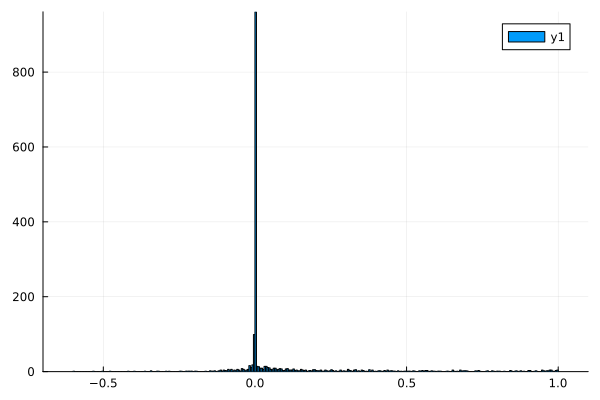

In [46]:
histogram(vec(isample))

In [47]:
ode_fn = Chain(Dense(n_in-1 => 129),)

Dense(13 => 129)    # 1_806 parameters

In [62]:
using SciMLSensitivity

In [88]:
model = Chain(
    PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01, sensealg=ZygoteAdjoint()),
    x -> complex_to_angle(Array(x))[:,:,1],
    #PhasorDense(129 => 3),
)

Chain(
    layer_1 = PhasorODE(
        model = Dense(13 => 129),       # 1_806 parameters
    ),
    layer_2 = WrappedFunction(#66),
)         # Total: 1_806 parameters,
          #        plus 0 states.

In [89]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, model)

((layer_1 = (weight = Float32[-0.018712677 0.1107008 … 0.028490463 -0.17449982; -0.13419782 -0.061662417 … -0.007198126 0.0038417287; … ; 0.081494965 0.14719523 … 0.044652175 -0.0032649965; 0.1624646 -0.042836018 … -0.12136633 0.16895476], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [90]:
y_naive, _ = model(fn0, ps, st);

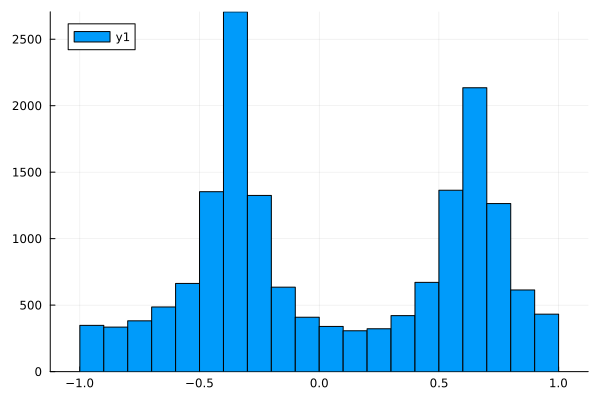

In [91]:
histogram(y_naive |> vec)

In [92]:
using Statistics: mean

In [93]:
function test_loss(model, ps, st)
    p0, _ = model(fn0, ps, st)
    err = mean(abs.(p0 .- 0.25))
    return err
end

test_loss (generic function with 1 method)

In [94]:
psa = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.018712677 0.1107008 … 0.028490463 -0.17449982; -0.13419782 -0.061662417 … -0.007198126 0.0038417287; … ; 0.081494965 0.14719523 … 0.044652175 -0.0032649965; 0.1624646 -0.042836018 … -0.12136633 0.16895476], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = Float32[])

In [95]:
test_loss(model, psa, st)

0.5205845995644908

In [96]:
aa = p -> test_loss(model, p, st)

#68 (generic function with 1 method)

In [97]:
aa(psa)

0.5205845995644908

In [ ]:
#TODO - convert charges to currents *beforehand* and then use the nice easy 2D linear interpolation algorithm
# instead of all this whacky stuff

In [98]:
Zygote.gradient(aa, psa)

LoadError: ArgumentError: new: too few arguments (expected 49)

In [76]:
v0, g0 = withgradient(aa, psa)

(val = 0.25, grad = ((layer_1 = (weight = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = Float32[]),))

In [301]:
v0 * 2

0.011582061934435823

In [302]:
opt_state = Optimisers.setup(Adam(3e-4), psa)
losses = []

Any[]

In [303]:
for i in 1:100
    lossval, gs = withgradient(aa, psa)
    append!(losses, lossval)
    opt_state, psa = Optimisers.update(opt_state, psa, gs[1])
end

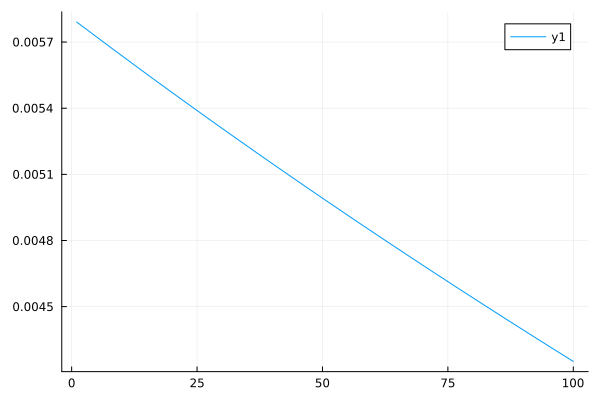

In [304]:
plot(losses)

In [271]:
y2, _  = model(fn0, psa, st);

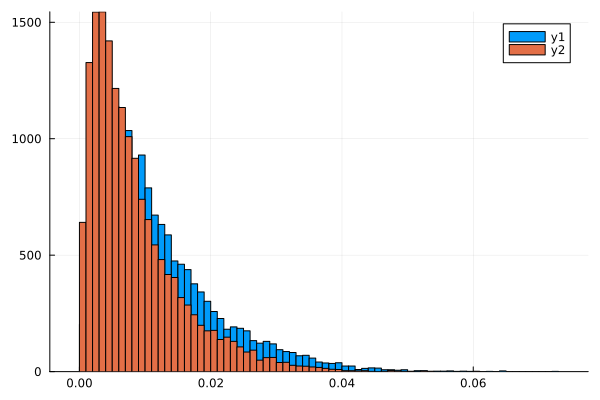

In [274]:
histogram(abs.(Array(y_naive)) |> vec)
histogram!(abs.(Array(y2)) |> vec)

In [275]:
aa(psa)

0.008474932f0

In [206]:
unique(vec(g0[1].layer_1.weight))

1-element Vector{ComplexF32}:
 0.0f0 + 0.0f0im

In [142]:
using Statistics: std, median, mean

In [143]:
using OneHotArrays

In [144]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [145]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [146]:
labels = momentum_to_label(pt)

LoadError: cannot assign a value to imported variable ComponentArrays.labels from module Main

In [42]:
logitcrossentropy(y_pred, y) = mean(-1 * sum(y .* logsoftmax(y_pred); dims=1))

logitcrossentropy (generic function with 1 method)

In [43]:
function loss(x, xl, y, model, ps, st, threshold)
    y_pred, st = model(process_inputs(x, xl), ps, st)
    y = momentum_to_label(y, threshold)
    loss = logitcrossentropy(y_pred, y)
    return loss, st
end

loss (generic function with 1 method)

In [44]:
loss(x, xl, y, model, ps, st, 0.2)

(1.1271271514814563, (layer_1 = (running_mean = [0.0, 0.0, 0.0, 0.0, 0.00023437500349245968, 0.05453125081257895, 0.01359375020256266, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07180550185123537], running_var = [0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.9000702886591898, 4.662564746791668, 1.098751701560718, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421  …  0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [46]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [47]:
loss_history, pst, stt = train(model, ps, st, train_loader, 0.2, epochs = 100)

[ Info: Constructing model and starting training


(Any[0.8351611768423041, 0.7848662134677522, 0.7652476515219051, 0.7530583928798679, 0.7445431295558399, 0.7380362964927526, 0.7327375132327211, 0.7282299136027719, 0.7239923407027486, 0.7205422148498812  …  0.6304898661307023, 0.6300576001083068, 0.6295956786515049, 0.629182441848811, 0.6287394774907336, 0.6282000829285144, 0.6277204515528716, 0.6271389866009607, 0.6266238326816836, 0.6261509859407995], (layer_1 = (scale = Float32[1.2878705, 1.040211, 0.91227466, 0.9777468, 1.1123227, 0.9168835, 0.9774908, 0.59404325, 0.6784739, 0.68271023  …  0.8060152, 0.70852166, 0.6148888, 0.80676097, 0.6363182, 0.8432124, 0.7099555, 0.8700544, 0.7635311, 1.8764266], bias = Float32[-0.04104466, 0.121392705, -0.10575298, 0.038687527, 0.116329364, 0.10111753, -0.0625818, -0.072762735, 0.17176424, 0.16924661  …  -0.060165245, -0.011441522, 0.018491823, 0.14405645, -0.057555243, 0.12899354, -0.13083193, 0.14631858, 0.14001414, 0.050688602]), layer_2 = (weight = Float32[-0.12679872 -0.0862036 … -0.1304

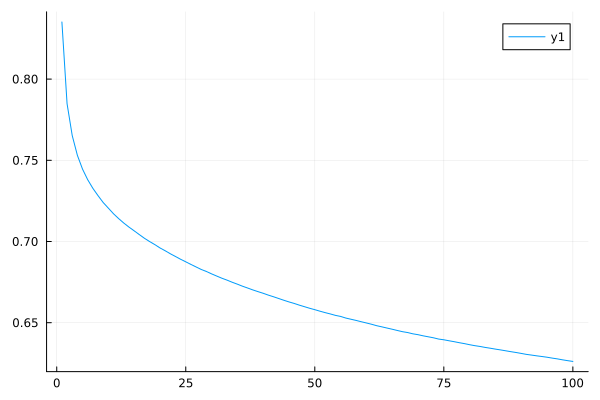

In [48]:
plot(loss_history)

In [49]:
loss_history2, pst2, stt2 = train(model, pst, stt, train_loader, 0.2, epochs = 100)

[ Info: Constructing model and starting training


(Any[0.6262443673844504, 0.6252783763383647, 0.6248326886278479, 0.6243156156205655, 0.6238009249165545, 0.6233510992962121, 0.6230186151043832, 0.6226373075891544, 0.6221607960868477, 0.6215249345585756  …  0.5964294207504952, 0.5962594291845961, 0.5959878316446008, 0.5958440354625061, 0.595551586820794, 0.5953419724820699, 0.5951715949936919, 0.5948228419339604, 0.5946114807093335, 0.5945365968008169], (layer_1 = (scale = Float32[1.4697739, 1.1580201, 1.0198406, 1.0529824, 1.3306414, 0.99830335, 1.1047245, 0.45129508, 0.61435616, 0.5544806  …  0.76070774, 0.45025367, 0.44715136, 0.68416, 0.38878638, 0.77557844, 0.4225336, 0.82894355, 0.6843885, 2.1894317], bias = Float32[0.0077468446, 0.10698929, -0.050629485, 0.05460481, 0.13481493, 0.10446353, -0.03299141, -0.026561724, 0.15873784, 0.14660995  …  -0.050419666, 0.010568192, 0.016822055, 0.15912247, -0.023819111, 0.13997678, -0.10000029, 0.1648359, 0.15047394, 0.028402999]), layer_2 = (weight = Float32[-0.05932214 -0.41674483 … -0.18

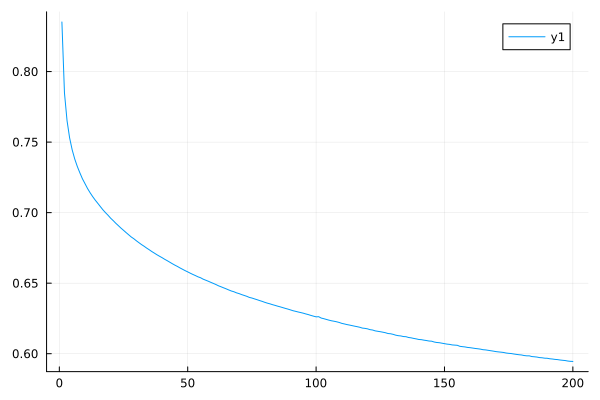

In [50]:
plot(vcat(loss_history, loss_history2))

In [51]:
pst = pst2

(layer_1 = (scale = Float32[1.4697739, 1.1580201, 1.0198406, 1.0529824, 1.3306414, 0.99830335, 1.1047245, 0.45129508, 0.61435616, 0.5544806  …  0.76070774, 0.45025367, 0.44715136, 0.68416, 0.38878638, 0.77557844, 0.4225336, 0.82894355, 0.6843885, 2.1894317], bias = Float32[0.0077468446, 0.10698929, -0.050629485, 0.05460481, 0.13481493, 0.10446353, -0.03299141, -0.026561724, 0.15873784, 0.14660995  …  -0.050419666, 0.010568192, 0.016822055, 0.15912247, -0.023819111, 0.13997678, -0.10000029, 0.1648359, 0.15047394, 0.028402999]), layer_2 = (weight = Float32[-0.05932214 -0.41674483 … -0.18414524 0.0541863; -0.19706695 0.05320552 … -0.07384117 -0.38292387; … ; -0.119156264 0.045651462 … 0.17305084 -0.08249801; -0.43498686 -0.23503207 … -0.120095365 -0.0051032878], bias = Float32[0.013542293; -0.27018693; … ; 0.21054368; -0.111689106;;]), layer_3 = (weight = Float32[0.15412416 0.101925105 … -0.016297584 0.009354383; -0.17179129 -0.1216197 … 0.13791005 -0.034549084; 0.19139546 -0.22807682 … -

In [52]:
sttf = Lux.testmode(stt2)

(layer_1 = (running_mean = [5.0124492126432925, 9.616352892243489, 17.52105674423773, 28.30641366391307, 41.27152711333373, 80.71897554812635, 89.4275271572422, 89.50799112251822, 89.67981627956817, 89.78702951599479  …  15.871412914187239, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 0.15291454619067543], running_var = [15178.192627907842, 33475.66116950288, 64053.40484324885, 150844.06092135684, 289316.54691077693, 869661.6668876838, 1.1103715446066877e6, 1.1136988046473477e6, 1.1146410157783215e6, 1.115135135158226e6  …  208441.34644549974, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple())

In [53]:
loss(x, xl, y, model, pst, sttf, 0.2)

(0.49975631991829567, (layer_1 = (running_mean = [5.0124492126432925, 9.616352892243489, 17.52105674423773, 28.30641366391307, 41.27152711333373, 80.71897554812635, 89.4275271572422, 89.50799112251822, 89.67981627956817, 89.78702951599479  …  15.871412914187239, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 0.15291454619067543], running_var = [15178.192627907842, 33475.66116950288, 64053.40484324885, 150844.06092135684, 289316.54691077693, 869661.6668876838, 1.1103715446066877e6, 1.1136988046473477e6, 1.1146410157783215e6, 1.115135135158226e6  …  208441.34644549974, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [54]:
loss_history[end]

0.6261509859407995

In [56]:
yt, _ = model(process_inputs(x, xl), pst, stt)

([-2.519516804982199 -1.1995193007577 … -4.224558226858901 -2.433261296710905; -0.10455519180957262 0.3949108881456629 … -2.8674384266207262 0.05839572546381888; -1.9044175503851382 0.8860764231493787 … 1.3112104513442362 0.8442173852517455], (layer_1 = (running_mean = [4.511204171872861, 8.65471737374742, 15.768950652079411, 25.47577162264427, 37.14460779301397, 72.70160731963594, 80.49836605960213, 80.55718987622959, 80.71183251347792, 80.80832442370571  …  14.284271244364543, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 0.2094285897770764], running_var = [13660.373003240746, 30128.09425443063, 57648.062831771786, 135759.6512328185, 260384.88539216772, 782699.2420293362, 999334.5624244238, 1.0023288976299643e6, 1.0031768876253767e6, 1.0036215950555098e6  …  187597.2068313208, 187598.66095729827, 187598.66095729827, 187598.66095729827, 187598.66095729827, 187598.66095729827, 1875

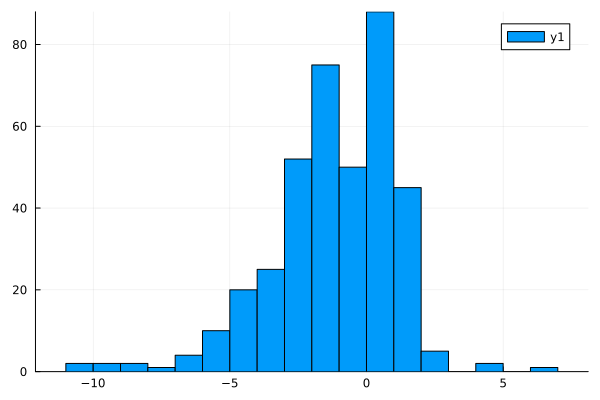

In [58]:
histogram(yt |> vec)

# Calculate the Test Loss

In [59]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [63]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    y_labels = onecold(y_pred, (0, 1, 2))
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [64]:
yth, _ = model(process_inputs(xts, xlts), pst, sttf)

([-8.951957053679283 -3.6941626634602707 … -3.4857271452095633 -3.470447021067624; -8.647090095462493 -5.304786819189028 … -0.5439040669813904 -0.8142507597652024; -2.6063647653432254 -0.7983498236050062 … -2.110489934836995 -1.4780349212831423], (layer_1 = (running_mean = [5.0124492126432925, 9.616352892243489, 17.52105674423773, 28.30641366391307, 41.27152711333373, 80.71897554812635, 89.4275271572422, 89.50799112251822, 89.67981627956817, 89.78702951599479  …  15.871412914187239, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 0.15291454619067543], running_var = [15178.192627907842, 33475.66116950288, 64053.40484324885, 150844.06092135684, 289316.54691077693, 869661.6668876838, 1.1103715446066877e6, 1.1136988046473477e6, 1.1146410157783215e6, 1.115135135158226e6  …  208441.34644549974, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.9

In [65]:
accuracy(xts, xlts, yts, model, pst, sttf, 0.2)

91

In [66]:
function confusion_matrix(prediction, truth, threshold::Real)
    truth = hcat(truth .== 1, truth .== 0)
    prediction = hcat(prediction .> threshold, prediction .<= threshold)

    confusion = truth' * prediction
    return confusion
end

confusion_matrix (generic function with 1 method)

In [67]:
using LinearAlgebra: diag

In [70]:
roc = tpr_fpr(yth, yts)

([0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625  …  0.9765625, 0.9765625, 0.984375, 0.984375, 0.984375, 0.984375, 0.984375, 0.9921875, 0.9921875, 0.9921875], [0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125  …  0.8515625, 0.859375, 0.859375, 0.859375, 0.87109375, 0.875, 0.8828125, 0.88671875, 0.8984375, 0.8984375])

In [73]:
roc_fn = interpolate_roc(roc)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    203-element Vector{Float64}:
│     0.0
│     0.0078125
│     0.0078125
│     0.0078125
│     0.0078125
│     ⋮
│     0.8828125
│     0.88671875
│     0.8984375
│     0.8984375
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


203-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 ⋮
 0.9765625
 0.9765625
 0.9765625
 0.984375
 0.984375
 0.984375
 0.984375
 0.984375
 0.9921875
 0.9921875
 0.9921875
 1.0

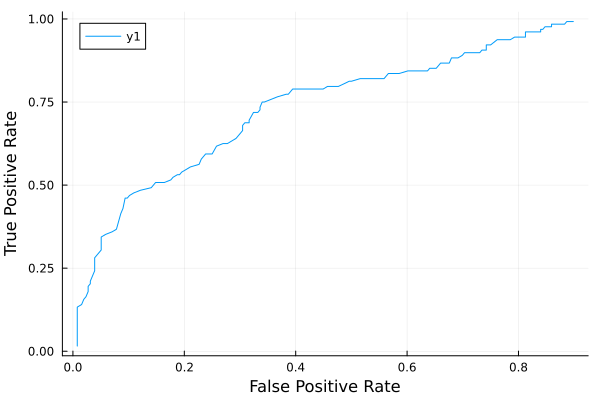

In [74]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

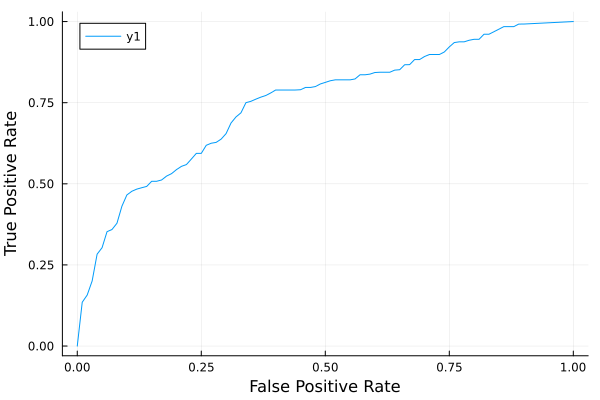

In [76]:
plot(roc_xs, roc_fn.(roc_xs))
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [78]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.749191262006996, 1.0611857134993838e-8)